## Statistical Analysis of Medical Insurance Claims

Link to Dataset: https://www.kaggle.com/datasets/mirichoi0218/insurance

Dataset Information:

- age: age of primary beneficiary

- sex: insurance contractor gender, female, male

- bmi: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height,
objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9

- children: Number of children covered by health insurance / Number of dependents

- smoker: Smoking

- region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.

- charges: Individual medical costs billed by health insurance

## Importing the libraries and dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Summary of the dataset

In [3]:
df.sex=df['sex'].astype("category")
df.smoker=df['smoker'].astype("category")
df.region=df['region'].astype("category")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   age       1338 non-null   int64   
 1   sex       1338 non-null   category
 2   bmi       1338 non-null   float64 
 3   children  1338 non-null   int64   
 4   smoker    1338 non-null   category
 5   region    1338 non-null   category
 6   charges   1338 non-null   float64 
dtypes: category(3), float64(2), int64(2)
memory usage: 46.3 KB


Our dataset has the following types of variables:
- Categorical varibles: sex, smoker, region, children
- Quantitative variables: age, bmi, charges. Here children is a discrete variable where as age, bmi, and charges are continous variables.

## Check for missing values

In [5]:
df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

## Descriptive Statistics of the Dataset

This shows us statistics that summarize the central tendency, dispersion and shape of a dataset’s distribution, excluding NaN values. 

In [6]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


**Observations:**
The following is observed from the descriptive statistics of the dataset.

- The average age of the primary beneficiary is 39.2 with the minimum age being 18 and maximum being 64.

- The average BMI is 30.66. The maximum BMI is 53.13 while the minimum is 15.96.

- On an average, the customer has 1 child.

- For `age`, `bmi` and `children`, the mean is almost equal to the median, suggesting that the data is normally distrubuted.

- The Average medical costs billed to health insurance is 13270, median is 9382, minimum is 1121.87 and maximum is 63770. The median of charges is less than the mean of charges which means that the distribution is positively skewed.

In [7]:
df.describe(include='category')

,sex,smoker,region
count,1338,1338,1338
unique,2,2,4
top,male,no,southeast
freq,676,1064,364


In [8]:
# Getting counts of the unique observations for each categorical variable 
column_lst =  df.select_dtypes(['category']).columns
for i in range(len(column_lst)):
    print(df[column_lst[i]].value_counts())

male      676
female    662
Name: sex, dtype: int64
no     1064
yes     274
Name: smoker, dtype: int64
southeast    364
northwest    325
southwest    325
northeast    324
Name: region, dtype: int64


**Observations:**
From the above, we can infer that:
- There are slightly more 'male' beneficiaries in the dataset compared to 'female' beneficiaries.
- Most of the benficiaries are non-smokers.
- Number of claims made by customers who live in the southeast region of the United States is more compared to other regions.

## Exploratory Data Analysis

### Univariate Analysis

##### Box Plot

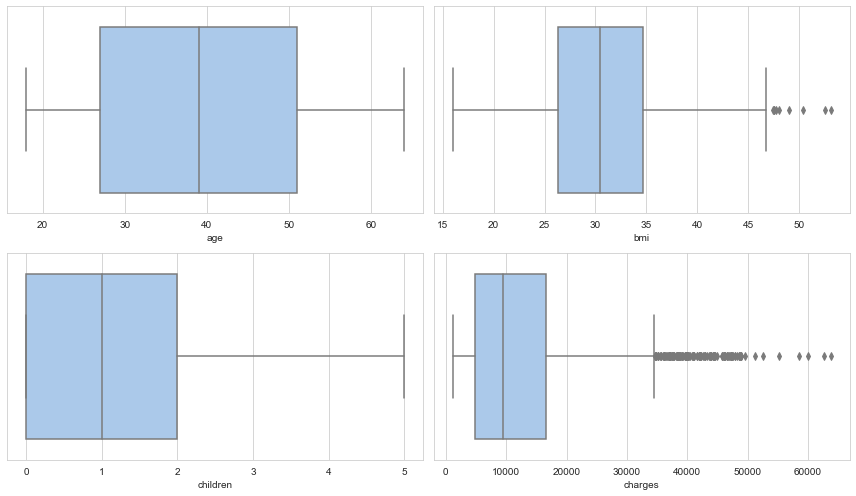

In [9]:
cols = 2
rows = 2
sns.set_palette("pastel")
sns.set_style("whitegrid")
num_cols = df.select_dtypes(exclude='category').columns
fig = plt.figure(figsize= (12,7))
for i, col in enumerate(num_cols):
    ax=fig.add_subplot( rows, cols, i+1)
    sns.boxplot(x=df[col], ax=ax)
    
fig.tight_layout()  
plt.show()

##### Histogram and Rug Plot

In [13]:
def plot_rug_hist(col_name):
    plt.figure(figsize= (12,7))
    sns.rugplot(x=col_name, data=df, height=.03, color='darkblue')
    sns.histplot(x=col_name, data=df, kde=True)
    plt.axvline(df[col_name].mean(), color='red', linestyle='--',linewidth=2, label='Mean')
    plt.axvline(df[col_name].median(), color='green', linestyle='--',linewidth=2, label='Median')
    plt.axvline(df[col_name].mode().tolist()[0], color='yellow', linestyle='--',linewidth=2, label='Mode')
    plt.legend()
    plt.show()

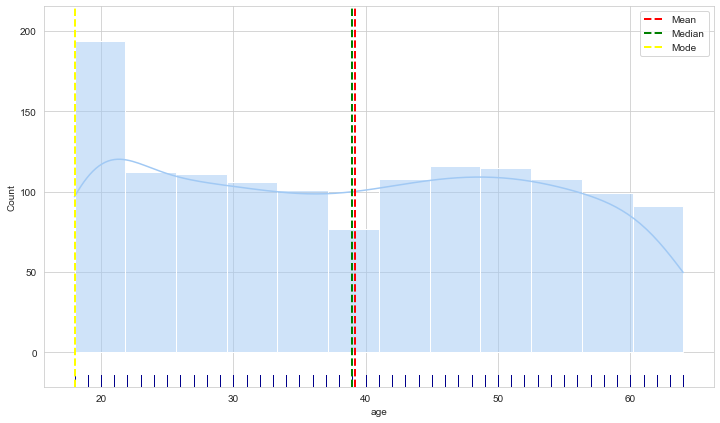

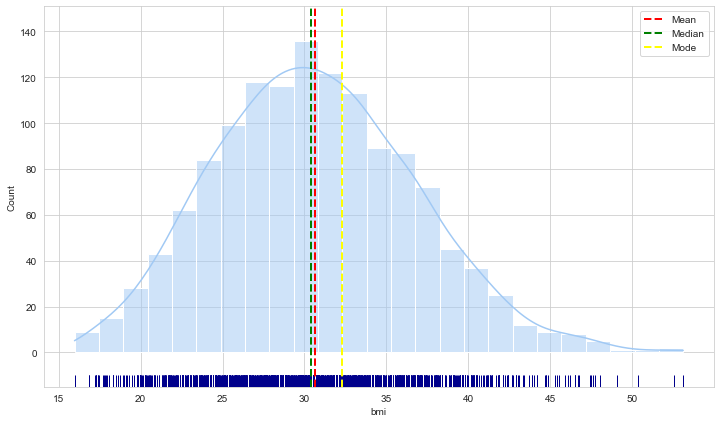

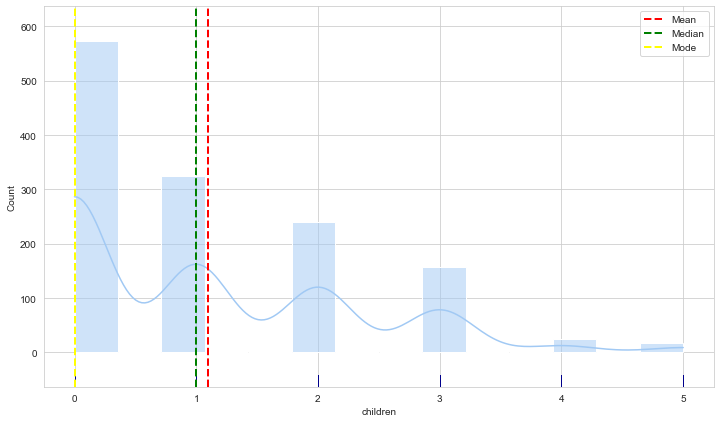

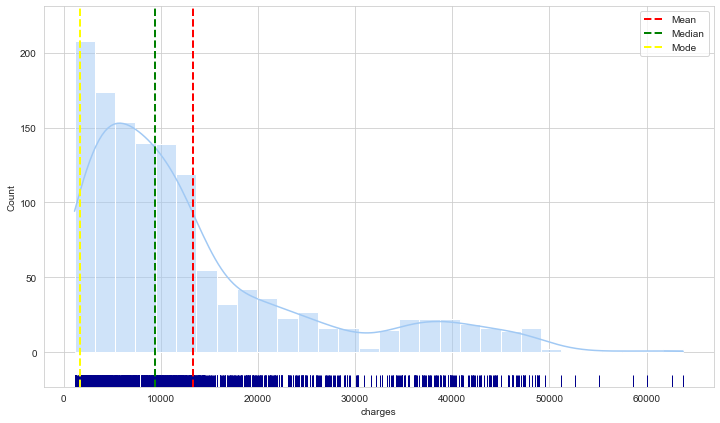

In [14]:
for i, col in enumerate(num_cols):
    plot_rug_hist(num_cols[i])

**Observations:**

- The age of primary beneficary lies approximately between 20 - 65 years. Since the mode is 18, we can safely say that majority of customer are 18 years old.
- BMI is normally distrubuted and the average BMI among the beneficiaries is 30 which is outside the normal range of BMI. It is also observed that there are lot of outliers at upper end.
- Majority of the beneficary have no children.
- The distribution for charges distrubution is unimodal and is right-skewed. There are lot of outliers at upper end.